# compute spectra on mitgcm outputs

---

In [1]:
import os
from glob import glob
import numpy as np
import dask
#from dask_jobqueue import PBSCluster
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft

from mitequinox.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
if dmethod == 2:
    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.47:8786 Dashboard: http://10.148.0.47:8787/status,Cluster Workers: 7 Cores: 98 Memory: 700.00 GB


--- 

# load data

In [ ]:
v = 'Eta'
face = 1

## open files, binary files
#data_dir = root_data_dir+v+'/'
#iters, time = get_iters_time(v, data_dir, delta_t=25.)
#ds = get_compressed_data('Eta', data_dir, grid_dir, iters='all', time=time, client=client)


## open files, nc files
#ncdata_dir = datawork+'/mit_nc_t/'
ncdata_dir = scratch+'/mit_nc_t/'
# search for right files, for example: Eta_f01_t*.nc
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
filenames = filenames[:2]
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset('/home1/scratch/aponte/mit_grid_t.nc')
#grid = xr.open_dataset('/home1/scratch/aponte/mit_grid_t.nc', chunks={'i':10, 'j':432})
#grid = xr.open_dataset('/home1/scratch/aponte/mit_grid_t.nc', chunks={'i':10, 'j':432}, decode_coords=True)
grid = grid.isel(face=face)
print(grid)

In [7]:
#%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
%time ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')

ds = ds.isel(time=slice(0,3000))

ds = xr.merge([ds,grid])

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 88 ms, sys: 16 ms, total: 104 ms
Wall time: 103 ms
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
  

In [8]:
#chunks={'time': len(ds['time']), 'face':1,  'i': 100, 'j': 100}
#chunks={'time': len(ds['time']), 'i': 10, 'j': 432}
chunks={'time': len(ds['time'])}
%time ds = ds.chunk(chunks)
print(ds)

CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 110 ms
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (i, j) float32 dask.array<shape=(4320, 4320), chunksi

In [9]:
#%time eta = ds['Eta'].isel(face=1).persist()
%time eta = ds['Eta'].persist()
#%time eta = ds['Eta']

CPU times: user 1.88 s, sys: 48 ms, total: 1.92 s
Wall time: 1.93 s


---

# spectral computations 

In [10]:
v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False).mean(dim=('i','j'))
E = E.astype('f8').rename('eta_power_spectrum ()')

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [11]:
%time E.load()

CPU times: user 23.6 s, sys: 264 ms, total: 23.9 s
Wall time: 3min 12s


<xarray.DataArray 'eta_power_spectrum ()' (freq_time: 480)>
array([5.928565e-10, 1.403779e+02, 2.312437e+02, ..., 8.740686e+01,
       2.312437e+02, 1.403779e+02])
Coordinates:
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07

No handles with labels found to put in legend.


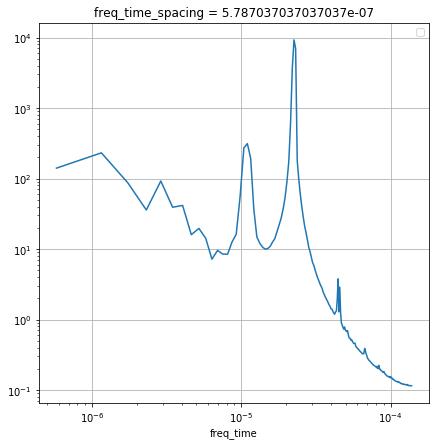

In [13]:
# and plot
fig, ax = plt.subplots(figsize=(7,7))
E.where(E.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
#ax.set_ylim([1e-1,1e5])

---
# i averaged

In [18]:
v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False).mean(dim=('i'))
E = E.astype('f8').rename('eta_power_spectrum ()')
%time E.load()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


CPU times: user 20.8 s, sys: 204 ms, total: 21 s
Wall time: 5min 39s


<xarray.DataArray 'eta_power_spectrum ()' (j: 4320, freq_time: 3000)>
array([[6.100417e-07, 1.709440e+04, 8.777749e+03, ..., 3.885412e+03,
        8.777749e+03, 1.709440e+04],
       [6.133078e-07, 1.695549e+04, 8.691818e+03, ..., 3.844150e+03,
        8.691818e+03, 1.695549e+04],
       [6.271161e-07, 1.682240e+04, 8.605289e+03, ..., 3.805105e+03,
        8.605289e+03, 1.682240e+04],
       ...,
       [6.401297e-08, 3.744548e+03, 6.442668e+02, ..., 3.887815e+02,
        6.442668e+02, 3.744548e+03],
       [7.888247e-08, 3.731280e+03, 6.406590e+02, ..., 3.971922e+02,
        6.406590e+02, 3.731280e+03],
       [5.328227e-08, 3.711034e+03, 6.334194e+02, ..., 4.055229e+02,
        6.334194e+02, 3.711034e+03]])
Coordinates:
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 9.259e-08 1.852e-07 2.778e-07 ...
    freq_time_spacing  float64 9.259e-08

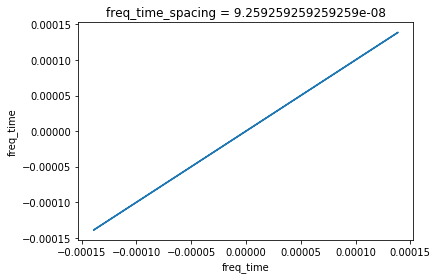

In [23]:
E['freq_time'].plot()
#E['j'].plot()

In [ ]:
# and plot
fig, ax = plt.subplots(figsize=(7,7))
plt.pcolormesh(np.log10(E.values))
#E.plot.pcolormesh(y=E['freq_time'], x=E['j'])
#np.log10(E).plot(ax=ax)
ax.legend(); ax.grid()
#ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel('');
#ax.set_ylim([1e-1,1e5])

No handles with labels found to put in legend.


In [17]:
ds['time'][1]-ds['time'][0]

<xarray.DataArray 'time' ()>
array(3600.)
Coordinates:
    face     int64 1

In [2]:
E.values()

NameError: name 'E' is not defined

---
# zonally averaged

In [28]:
v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
print(v_fft)
print(eta)

<xarray.DataArray 'fftn-a42c5cc1bb1c29090f2c46b0b037c13b' (i: 4320, j: 4320, freq_time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=complex128, chunksize=(10, 432, 480)>
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07
<xarray.DataArray 'Eta' (i: 4320, j: 4320, time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=float32, chunksize=(10, 432, 480)>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
    XC       (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC       (i, j) float32 dask.array<s

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [11]:
dlat = 1.
f = v_fft.freq_time
#f = f.where(f>0, drop=True)
print(f)

<xarray.DataArray 'freq_time' (freq_time: 480)>
array([ 0.000000e+00,  5.787037e-07,  1.157407e-06, ..., -1.736111e-06,
       -1.157407e-06, -5.787037e-07])
Coordinates:
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07


In [12]:
#eta.YC.min().values
grid.YC.min().values

array(-57.00102615)

In [14]:
v1b = {'min': dlat*np.ceil(eta.YC.min().values/dlat),'max': dlat*np.floor(eta.YC.max().values/dlat), 'd': dlat}
#v2b = {'min': v_fft.freq_time.min().values, 'max': v_fft.freq_time.max().values, 'd': v_fft.freq_time[1]-v_fft.freq_time[0]}
v2b = {'min': f.min().values, 'max': f.max().values, 'd': f[1]-f[0]}
#v1min, v1max, dv1= dlat*np.ceil(ds.YC.min().values/dlat), dlat*np.floor(ds.YC.max().values/dlat), 1.
#v2min, v2max, dv2= v_fft.freq_time.min().values, v_fft.freq_time.max().values, v_fft.freq_time[1]-v_fft.freq_time[0]

In [15]:
def fmap(v1,v2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        i1max = np.int(np.rint((v1b['max']-v1b['min'])/v1b['d']))+1
        i2max = np.int(np.rint((v2b['max']-v2b['min'])/v2b['d']))+1
        #
        i1 = np.maximum(np.rint((v1-v1b['min'])/v1b['d'])+1,0)
        i1 = np.minimum(i1,i1max)
        #
        i2 = np.maximum(np.rint((v2-v2b['min'])/v2b['d'])+1,0)
        i2 = np.minimum(i2,i2max)
        return i1+i2*(i1max+1)

#def imap(i)
#    return lat, f

def printb(v,label):
    print('%s: min %e, max %e, step %e '%(label, v['min'], v['max'], v['d']) )

printb(v1b, 'lat')
printb(v2b, 'freq')

print(fmap(-40.,1e-3))
    

lat: min -5.700000e+01, max 1.300000e+01, step 1.000000e+00 
freq: min -1.388889e-04, max 1.383102e-04, step 5.787037e-07 
<xarray.DataArray 'freq_time' ()>
array(34578.)
Coordinates:
    freq_time_spacing  float64 5.787e-07


In [16]:
lat = ds.YC + 0*v_fft.freq_time
f = ds.YC*0. + v_fft.freq_time
print(lat)
print(f)

<xarray.DataArray (j: 4320, i: 4320, freq_time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=float64, chunksize=(4320, 4320, 480)>
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    face               int64 1
    XC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    rA                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    Depth              (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07
<xarray.DataArray (j: 4320, i: 4320, freq_time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=float64, chunksize=(4320, 4320, 480)>
Coordinates:
  * i              

In [ ]:
i = fmap(lat, f)
print(i)

i.isel(i=slice(0,100), j=slice(0,100), freq_time=0).plot()

In [27]:
    
# apply get_index to v1 and v2 arrays
v12 = dask.array.map_blocks(fmap, lat.data, f.data, dtype='float')
# compute histogram of linear indices
#h, lbins = dask.array.histogram(v12, bins=np.arange(-.5,(i1max+1)*(i2max+1)+0.5,1.))
print(v12)

dask.array<fmap, shape=(4320, 4320, 480), dtype=float64, chunksize=(4320, 4320, 480)>


In [37]:
#v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False) #.groupby('YC') #.mean(dim=('i'))
E = xr.merge([E,grid])
dlat = 1.
lat_bins = dlat*np.arange(np.ceil(E.YC.min().values/dlat), np.floor(E.YC.max().values/dlat))
print(lat_bins)
print(E)
E = E.groupby_bins('YC', lat_bins) #.mean(dim=['i','j'])
print(E)
#E = E.astype('f8').rename('eta_power_spectrum ()')
#%time E.load()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[-57. -56. -55. -54. -53. -52. -51. -50. -49. -48. -47. -46. -45. -44.
 -43. -42. -41. -40. -39. -38. -37. -36. -35. -34. -33. -32. -31. -30.
 -29. -28. -27. -26. -25. -24. -23. -22. -21. -20. -19. -18. -17. -16.
 -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.
  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.]
<xarray.Dataset>
Dimensions:                                (freq_time: 480, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i                                      (i) int64 0 1 2 3 4 5 6 7 8 9 10 ...
  * j                                      (j) int64 0 1 2 3 4 5 6 7 8 9 10 ...
  * freq_time                              (freq_time) float64 0.0 5.787e-07 ...
    freq_time_spacing                      float64 5.787e-07
  * i_g                                    (i_g) int64 0 1 2 3 4 5 6 7 8 9 ...
  * j_g                                    (j_g) int64 0 1 2 3 4 5 6 7 8 9 ...
  * k              

--- 

# store spectra

In [10]:
v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False)
E = E.astype('f8').rename('E_eta')
print(E)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


<xarray.DataArray 'eta_power_spectrum (??)' (i: 4320, j: 4320, freq_time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=float64, chunksize=(10, 432, 480)>
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07


In [11]:
file_E = scratch+'/mit_spec/E.nc'

In [ ]:
E = xr.merge([E, grid])
E.to_netcdf(file_E,mode='w')
# should transpose?

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:742: UserWarning: Large object of size 1.89 MB detected in task graph: 
  ("('where-astype-d54a3c5db2cc5e42f2e4717b3b22b00c' ... b16f>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


### load E

In [6]:
file_E = scratch+'/mit_spec/E.nc'
#Enc = xr.open_dataset(file_E, chunks={'freq_time': 1})
Enc = xr.open_dataset(file_E, chunks={'i': 1})
Enc.rename({'eta_power_spectrum (??)': 'E_eta'}, inplace=True) # tmp
Enc.drop(['XG','YG']) # tmp, should be dropped while creating spectrum
Enc = Enc.persist()
print(Enc)

<xarray.Dataset>
Dimensions:            (freq_time: 480, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 ...
  * i_g                (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * j_g                (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * k                  (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * k_u                (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * k_l                (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * k_p1               (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    face               int64 ...
    XC                 (i, j) float32 dask.array<shape=(4320, 

In [7]:
print(Enc['YC'])
dlat=1.
#v1b = {'min': dlat*np.ceil(grid.YC.min().values/dlat),'max': dlat*np.floor(grid.YC.max().values/dlat), 'd': dlat}
#lat_bins = np.arange(dlat*np.ceil(Enc.YC.min().values/dlat),dlat*np.floor(Enc.YC.max().values/dlat),dlat)
lat_bins = np.arange(-60.,60.,dlat)
lat_center = (lat_bins[:-1]+lat_bins[1:])*.5

<xarray.DataArray 'YC' (i: 4320, j: 4320)>
dask.array<shape=(4320, 4320), dtype=float32, chunksize=(1, 4320)>
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    freq_time_spacing  float64 ...
    face               int64 ...
    XC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    YC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    rA                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    Depth              (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    coordinate:     YC XC


In [21]:
#Enc = xr.merge([Enc, grid])
#print(Enc)

In [8]:
# look at one frequency first
%time Ef0 = Enc.isel(freq_time=0, drop=False).groupby_bins('YC', lat_bins).mean()

CPU times: user 43.8 s, sys: 1.59 s, total: 45.4 s
Wall time: 53.6 s


In [9]:
Ef = Ef0.assign_coords(lat=xr.DataArray(lat_center,dims=['YC_bins'])).drop('YC_bins')
print(Ef)

<xarray.Dataset>
Dimensions:  (YC_bins: 69)
Coordinates:
    lat      (YC_bins) float64 -56.5 -55.5 -54.5 -53.5 -52.5 -51.5 -50.5 ...
Dimensions without coordinates: YC_bins
Data variables:
    E_eta    (YC_bins) float64 dask.array<shape=(69,), chunksize=(1,)>


In [10]:
%time Ef.to_netcdf(scratch+'/mit_spec/E_%03d.nc'%0, mode='w')

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:742: UserWarning: Large object of size 187.41 MB detected in task graph: 
  ("('concatenate-ba831207edf0e9e9ab900a73aef020d1', ... 3860>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))

KeyboardInterrupt



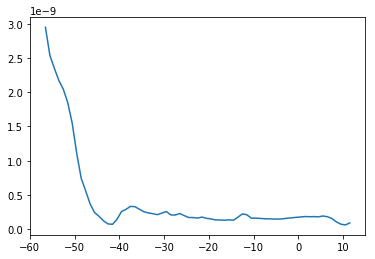

In [21]:
plt.plot(lat_center, Ef['eta_power_spectrum (??)'].values)

In [ ]:

Eb = xr.concat([Enc['E_eta'].isel(freq_time=i).groupby_bins('YC', lat_bins).mean().expand_dims(dim='f', axis=1) \
    for i in range(len(Enc.freq_time))], dim='f')
#len(Enc.freq_time)

# should maybe store data with an explicit for loop?
# this is not performant but should work

print(Eb)
#print(Eb.values)

In [ ]:
for i in range(len(Enc['freq_time'])):
    Ef = Enc['E_eta'].isel(freq_time=i).groupby_bins('YC', lat_bins).mean()
    Ef = Ef.expand_dims(dim='f', axis=1)
    Ef = Ef.assign_coords(lat=xr.DataArray(lat_center,dims=['YC_bins'])).drop('YC_bins')    
    Ef.to_netcdf(scratch+'/mit_spec/E_%03d.nc'%i, mode='w')
    print(i)

### with dask objects

In [7]:
print(Enc)

<xarray.Dataset>
Dimensions:            (freq_time: 480, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 ...
  * i_g                (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * j_g                (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * k                  (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * k_u                (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * k_l                (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * k_p1               (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    face               int64 ...
    XC                 (i, j) float32 dask.array<shape=(4320, 

In [8]:
lat = Enc['YC']
f = Enc['freq_time']

dlat=1.

v1b = {'min': -60.,'max': 60., 'd': dlat}
v2b = {'min': f.min().values, 'max': f.max().values, 'd': f[1].values-f[0].values}

i1max = np.int(np.rint((v1b['max']-v1b['min'])/v1b['d']))+1
i2max = np.int(np.rint((v2b['max']-v2b['min'])/v2b['d']))+1

def fmap(v1,v2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-v1b['min'])/v1b['d'])+1,0)
        i1 = np.minimum(i1,i1max)
        #
        i2 = np.maximum(np.rint((v2-v2b['min'])/v2b['d'])+1,0)
        i2 = np.minimum(i2,i2max)
        return i1+i2*(i1max+1)

#def imap(i)
#    return lat, f

def printb(v,label):
    print('%s: min %e, max %e, step %e '%(label, v['min'], v['max'], v['d']) )

printb(v1b, 'lat')
printb(v2b, 'freq')

print(fmap(-40., 1e-3))


lat: min -6.000000e+01, max 6.000000e+01, step 1.000000e+00 
freq: min -1.388889e-04, max 1.383102e-04, step 5.787037e-07 
58581.0


In [20]:
lat2 = lat + f*0.
f2 = lat*0. + f
# reset land data
lat2 = (lat2 + 0.*Enc['E_eta']).fillna(-100.)
#
#lat2, f2 = xr.broadcast(lat,f) # f2 is not a dask array chunked along i
#f2 = f2.chunk({'i':1})
#
f2 = f2.persist()


print(lat2)
print(f2)

<xarray.DataArray (i: 4320, j: 4320, freq_time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=float64, chunksize=(1, 4320, 480)>
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    freq_time_spacing  float64 5.787e-07
    face               int64 1
    XC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    YC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    rA                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    Depth              (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
<xarray.DataArray (i: 4320, j: 4320, freq_time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=float64, chunksize=(1, 4320, 480)>
Coordinates:
  * i                  (i) int64 0 1 

In [21]:
# apply get_index to v1 and v2 arrays
i = dask.array.map_blocks(fmap, lat2.data, f2.data, dtype='float')
print(i)

dask.array<fmap, shape=(4320, 4320, 480), dtype=float64, chunksize=(1, 4320, 480)>


In [29]:
dA = Enc['rA'] + 0.*f2
EdA = Enc['E_eta'].fillna(0.)*dA
print(dA)
print(EdA)

<xarray.DataArray (i: 4320, j: 4320, freq_time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=float64, chunksize=(1, 4320, 480)>
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    freq_time_spacing  float64 5.787e-07
    face               int64 1
    XC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    YC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    rA                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    Depth              (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
<xarray.DataArray (i: 4320, j: 4320, freq_time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=float64, chunksize=(1, 4320, 480)>
Coordinates:
  * i                  (i) int64 0 1 

In [30]:
# compute histogram of linear indices
h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(i1max+1)*(i2max+1)+0.5,1.), \
                                weights=EdA.data)
hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(i1max+1)*(i2max+1)+0.5,1.), \
                                weights=dA.data)

In [31]:
# normalize and reshape
H = h.compute()
Hnorm = hnorm.compute()
H = H/Hnorm
H = H.reshape((i1max+1,i2max+1), order='F')

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [24]:
H

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


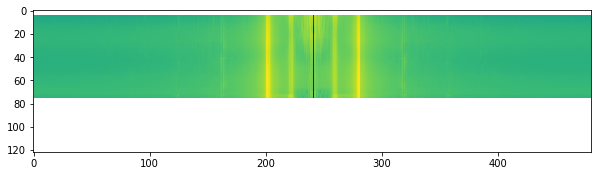

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(np.log10(H))

### with dask delayed

In [18]:
from dask import compute, delayed

In [19]:
def process(lE, i):    
    Ef = lE['eta_power_spectrum (??)'].groupby_bins('YC', lat_bins).mean()
    Ef.to_netcdf(scratch+'/mit_spec/E_%03d.nc'%i)
    return Ef.mean()

I = range(len(Enc['freq_time']))
values = [delayed(process)(Enc.isel(freq_time=i),i) for i in I]

In [ ]:
%time results = compute(*values, get=client.get)
# Large object of size 74.80 MB detected in task graph

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:742: UserWarning: Large object of size 74.80 MB detected in task graph: 
  ([[["('getitem-57f7f9562bff9d4baa84364946dcfc7e',  ... (), None, None)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


In [ ]:
lat = Enc.YC + 0.*Enc.freq_time
f = Enc.YC*0. + Enc.freq_time
print(lat)
print(f)

In [ ]:
i = fmap(lat, f)
print(i)

In [ ]:
i.isel(i=slice(0,100), j=slice(0,100), freq_time=0).plot()

In [ ]:
grid = xr.open_dataset('/home1/scratch/aponte/mit_grid.nc')
grid = grid.isel(face=face)
print(grid)
%time print(grid['YC'].mean().values)

In [ ]:
grid = xr.open_dataset('/home1/scratch/aponte/mit_grid.nc', chunks={'i':10, 'j':432})
grid = grid.isel(face=face)
print(grid)
%time print(grid['YC'].mean().values)

---

In [13]:
client.restart()

Client Scheduler: tcp://10.148.0.44:8786 Dashboard: http://10.148.0.44:8787/status,Cluster Workers: 7 Cores: 98 Memory: 700.00 GB


In [14]:
print(datawork)

/home1/datawork/aponte


In [ ]:

data_dir = root_data_dir+'Eta/'

iters, time = get_iters_time('Eta', data_dir, delta_t=25.)

ds = get_compressed_data('Eta', data_dir, grid_dir, iters='all', time=time, client=client)
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))
